In [64]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import re
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

input/train.txt
input/test.txt
input/val.txt


# Loading Data


In [65]:
def load_dataset(filepath):
    data = []
    with open(filepath) as f:
        lines = f.readlines()
        for line in lines:
            data.append(line.strip().split(";"))
    return pd.DataFrame(data, columns=["text", "emotion"])

In [66]:
train_data = load_dataset("input/train.txt")
validation_data = load_dataset("input/val.txt")
test_data = load_dataset("input/test.txt")

In [67]:
df = pd.concat([train_data, validation_data, test_data])
df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [68]:
df.shape

(20000, 2)

# EDA


In [69]:
lemmatizer = nltk.stem.WordNetLemmatizer()
stopwords = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.snowball.SnowballStemmer("english")

In [70]:
df.isnull().sum()

text       0
emotion    0
dtype: int64

In [71]:
df.duplicated().sum()

1

In [72]:
df.drop_duplicates(inplace=True)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19999 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     19999 non-null  object
 1   emotion  19999 non-null  object
dtypes: object(2)
memory usage: 468.7+ KB


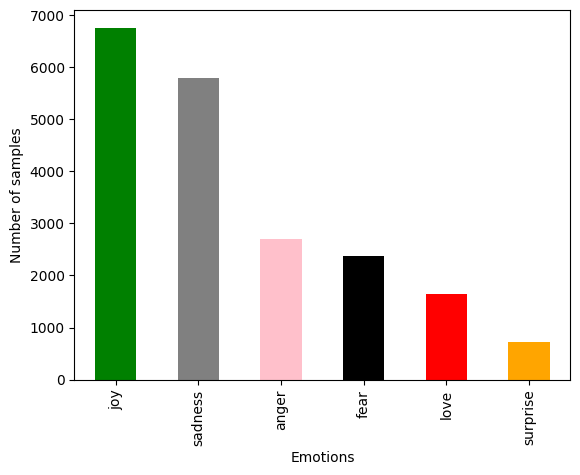

In [74]:
df["emotion"].value_counts().plot(
    kind="bar", color=["green", "gray", "pink", "black", "red", "orange"]
)
plt.xlabel("Emotions")
plt.ylabel("Number of samples")
plt.show()

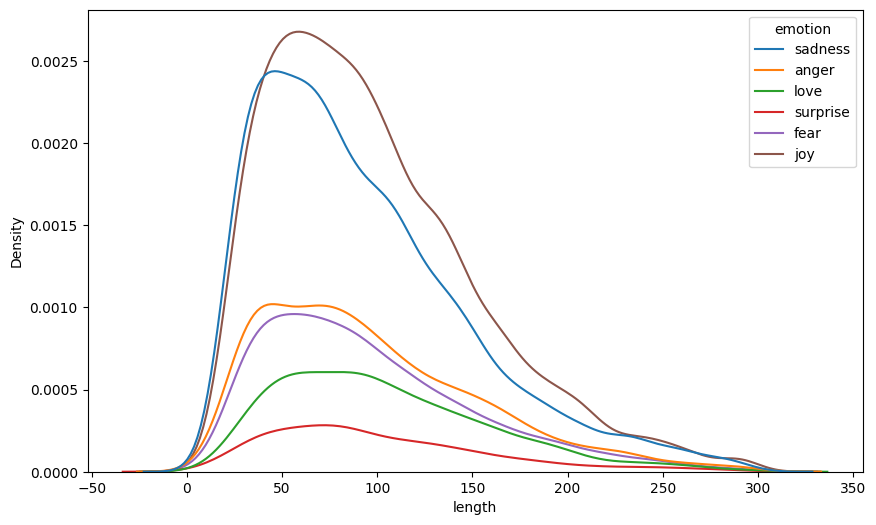

In [75]:
df["length"] = df.text.apply(lambda x: len(x))
fig = plt.figure(figsize=(10, 6))
sns.kdeplot(x=df["length"], hue=df["emotion"])
plt.show()

# Text Preprocessing


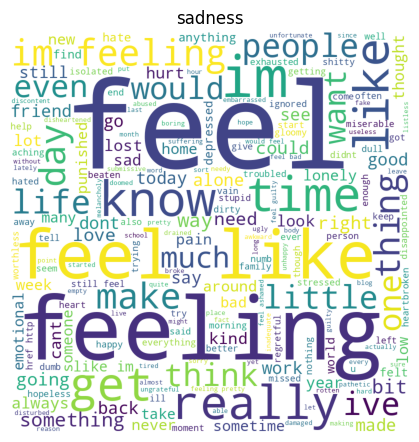

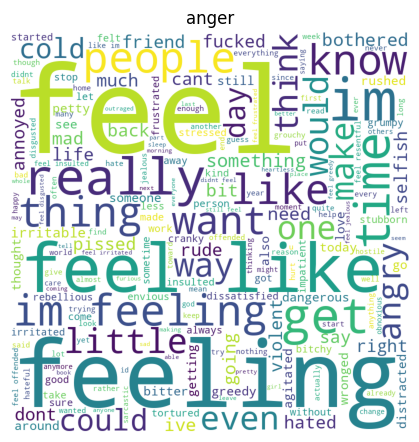

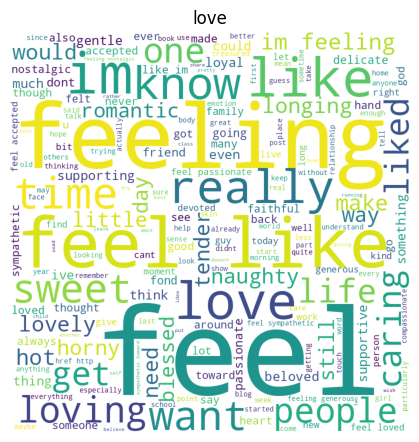

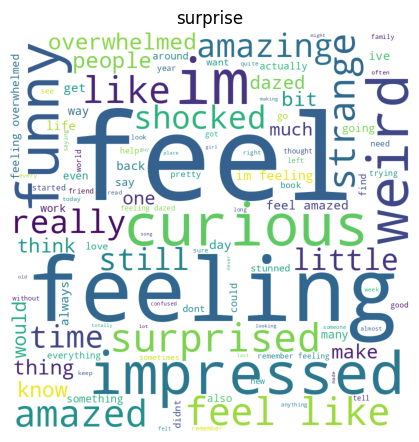

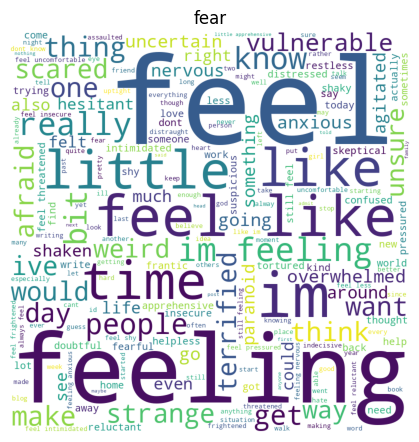

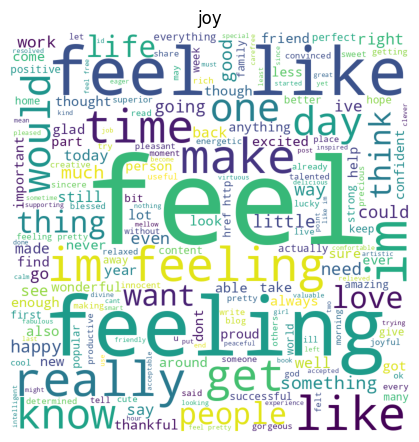

In [76]:
emotions = df["emotion"].unique()
for emotion in emotions:
    text = " ".join(df[df["emotion"] == emotion]["text"])
    wordcloud = WordCloud(
        width=800,
        height=800,
        background_color="white",
        stopwords=stopwords,
        min_font_size=10,
    ).generate(text)
    plt.figure(figsize=(4, 4), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(emotion)
    plt.show()

# Modeling


In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["emotion"], test_size=0.2, random_state=42
)

In [78]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

**Random Forest**


In [79]:
rf = RandomForestClassifier(n_estimators=100, random_state=100)
rf.fit(X_train_cv, y_train)

RandomForestClassifier(random_state=100)

In [80]:
y_pred_rf = rf.predict(X_test_cv)

In [81]:
report_rf = classification_report(y_test, y_pred_rf)
print("Classification report of Random Forest classifier:\n", report_rf)

Classification report of Random Forest classifier:
               precision    recall  f1-score   support

       anger       0.90      0.84      0.87       537
        fear       0.80      0.82      0.81       441
         joy       0.85      0.94      0.89      1334
        love       0.88      0.71      0.79       330
     sadness       0.93      0.90      0.91      1203
    surprise       0.80      0.68      0.73       155

    accuracy                           0.87      4000
   macro avg       0.86      0.82      0.83      4000
weighted avg       0.87      0.87      0.87      4000



**Logistic Regression**


In [82]:
lr = LogisticRegression(max_iter=1000, random_state=100)
lr.fit(X_train_cv, y_train)

LogisticRegression(max_iter=1000, random_state=100)

In [83]:
y_pred_lr = lr.predict(X_test_cv)

In [84]:
report_lr = classification_report(y_test, y_pred_lr)
print("Classification report of Logistic Regression (Multi-Class):\n", report_lr)

Classification report of Logistic Regression (Multi-Class):
               precision    recall  f1-score   support

       anger       0.91      0.88      0.89       537
        fear       0.83      0.83      0.83       441
         joy       0.91      0.94      0.92      1334
        love       0.84      0.79      0.82       330
     sadness       0.93      0.94      0.94      1203
    surprise       0.81      0.70      0.75       155

    accuracy                           0.90      4000
   macro avg       0.87      0.85      0.86      4000
weighted avg       0.90      0.90      0.90      4000



**Naive Bayes**


In [85]:
nb = MultinomialNB()
nb.fit(X_train_cv, y_train)

MultinomialNB()

In [86]:
y_pred_nb = nb.predict(X_test_cv)

In [87]:
report_nb = classification_report(y_test, y_pred_nb)
print("Classification report of Multinomial Naive Bayes:\n", report_nb)

Classification report of Multinomial Naive Bayes:
               precision    recall  f1-score   support

       anger       0.91      0.61      0.73       537
        fear       0.84      0.51      0.64       441
         joy       0.72      0.96      0.82      1334
        love       0.92      0.25      0.39       330
     sadness       0.75      0.93      0.83      1203
    surprise       1.00      0.02      0.04       155

    accuracy                           0.76      4000
   macro avg       0.86      0.55      0.57      4000
weighted avg       0.79      0.76      0.73      4000



**SVM**


In [88]:
svm = LinearSVC(random_state=100, max_iter=2000, dual=True)
svm.fit(X_train_cv, y_train)

LinearSVC(dual=True, max_iter=2000, random_state=100)

In [89]:
y_pred_svm = svm.predict(X_test_cv)

In [90]:
report_svm = classification_report(y_test, y_pred_svm)
print("Classification report of Linear SVM:\n", report_svm)

Classification report of Linear SVM:
               precision    recall  f1-score   support

       anger       0.89      0.88      0.89       537
        fear       0.83      0.83      0.83       441
         joy       0.91      0.93      0.92      1334
        love       0.80      0.79      0.80       330
     sadness       0.93      0.93      0.93      1203
    surprise       0.81      0.70      0.75       155

    accuracy                           0.89      4000
   macro avg       0.86      0.84      0.85      4000
weighted avg       0.89      0.89      0.89      4000



**LSTM**


In [91]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
emotions = le.classes_

In [92]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [93]:
max_len = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

In [99]:
model = Sequential()
model.add(Input(shape=(max_len,)))
model.add(Embedding(input_dim=5000, output_dim=32))
model.add(LSTM(32))
model.add(Dense(len(emotions), activation="softmax"))
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

In [100]:
early_stop = EarlyStopping(monitor="val_loss", patience=3)
history = model.fit(
    X_train_padded, y_train, epochs=30, validation_split=0.2, callbacks=[early_stop]
)

Epoch 1/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.3320 - loss: 1.6058 - val_accuracy: 0.3425 - val_loss: 1.5846
Epoch 2/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3401 - loss: 1.5767 - val_accuracy: 0.3425 - val_loss: 1.5853
Epoch 3/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.3401 - loss: 1.5712 - val_accuracy: 0.3425 - val_loss: 1.5847
Epoch 4/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.3361 - loss: 1.5591 - val_accuracy: 0.3425 - val_loss: 1.5834
Epoch 5/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.3327 - loss: 1.5771 - val_accuracy: 0.3425 - val_loss: 1.5832
Epoch 6/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3424 - loss: 1.5676 - val_accuracy: 0.3378 - val_loss: 1.5779
Epoch 7/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3420 - loss: 1.5640 - val_accuracy: 0.3425 - val_loss: 1.5827
Epoch 8/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3323 - loss: 1.5678 - val_accu

In [103]:
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=emotions, zero_division=0)
print("Accuracy:", accuracy)
print("Classification report of LSTM:\n", report)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.3335
Classification report of LSTM:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00       537
        fear       0.00      0.00      0.00       441
         joy       0.33      1.00      0.50      1334
        love       0.00      0.00      0.00       330
     sadness       0.00      0.00      0.00      1203
    surprise       0.00      0.00      0.00       155

    accuracy                           0.33      4000
   macro avg       0.06      0.17      0.08      4000
weighted avg       0.11      0.33      0.17      4000



**Thankyou for spending your valuable time here!**
